**TruncatedSVD** is very similar to **PCA**, but differs in that the matrix **X**  does not need to be centered. When the columnwise (per-feature) means of **X** are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA. In practical terms, this means that the TruncatedSVD transformer accepts `scipy.sparse` matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections.

While the **TruncatedSVD** transformer works with any feature matrix, using it on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting. In particular, sublinear scaling and inverse document frequency should be turned on (`sublinear_tf=True, use_idf=True`) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.

more [here](https://scikit-learn.org/stable/modules/decomposition.html#lsa)

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in **sklearn.feature_extraction.text**. In that context, it is known as latent semantic analysis (LSA).

This estimator supports two algorithms: a fast randomized SVD solver, and a “naive” algorithm that uses ARPACK as an eigensolver on `X * X.T` or `X.T * X`, whichever is more efficient.

[sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

# Preparing the data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model Truncated SVD

In [8]:
class ModelTSVD:
    
    def __init__(self, n_components):
        self.n_components=n_components
        
    # spe: squared prediction errors
    def spe(self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)
   
    def train(self, df_train):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        if self.n_components == 0:
            self.m = sklearn.decomposition.TruncatedSVD()
        else:
            self.m = sklearn.decomposition.TruncatedSVD(n_components=self.n_components)
            # Learn the inverse transform for non-precomputed kernels (i.e. learn
            # to find the pre-image of a point). This method is based on [2]
           
        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test-self.mu_train)/self.std_train) 
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

# Training the Data

In [9]:
models = {'TSVD': ModelTSVD(0)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [10]:
detection_limits

{'TSVD': 104.68444114700739}

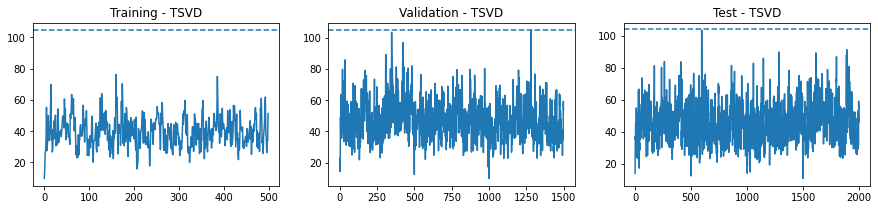

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - TSVD')
plt.axhline(detection_limits['TSVD'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - TSVD')
plt.axhline(detection_limits['TSVD'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - TSVD')
plt.axhline(detection_limits['TSVD'], ls = '--')

# Testing the Data

TSVD    52.925
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
TSVD,99.375,98.25,0.0,22.0,19.375,100.0,100.0,97.5,0.0,2.0,32.0,96.125,90.375,99.75,0.0,2.5,73.75,91.625,0.75,33.125


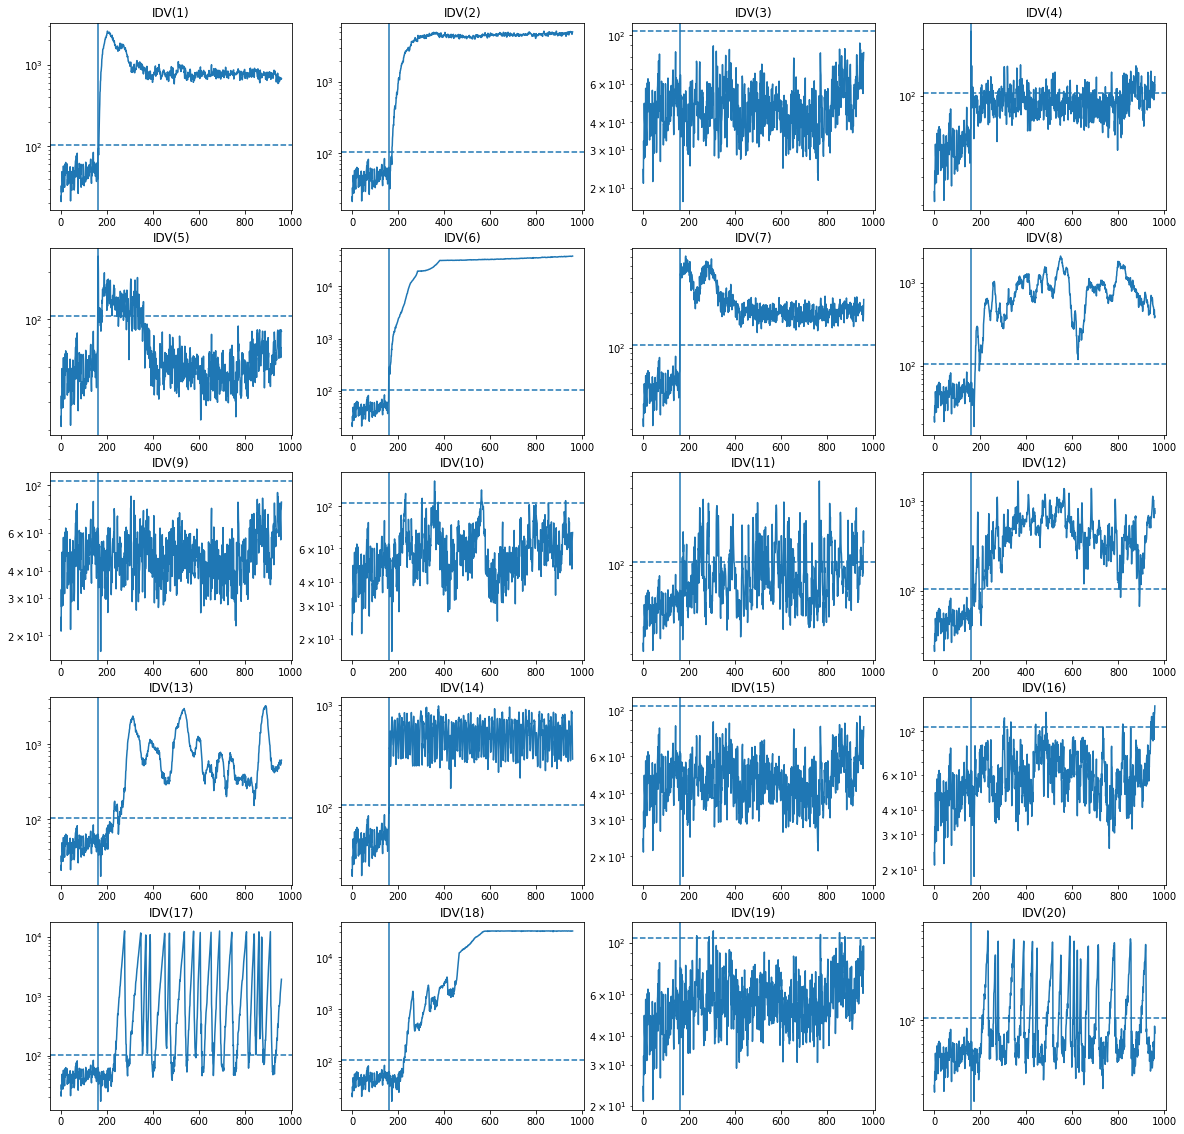

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

# Training the data with 30 n_components in the model

In [13]:
models = {'TSVD30': ModelTSVD(30)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [14]:
detection_limits

{'TSVD30': 25.45585062053249}

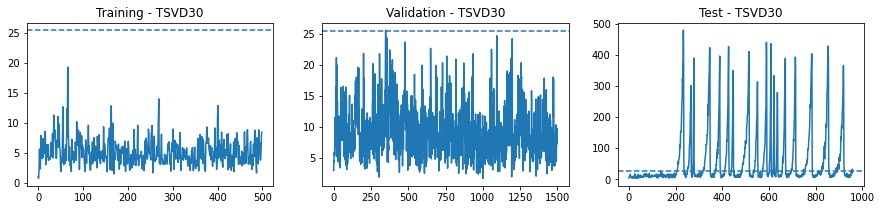

In [15]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - TSVD30')
plt.axhline(detection_limits['TSVD30'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - TSVD30')
plt.axhline(detection_limits['TSVD30'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - TSVD30')
plt.axhline(detection_limits['TSVD30'], ls = '--')

# Testing the new model

TSVD30    58.9875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
TSVD30,99.625,98.0,0.75,87.25,15.625,100.0,99.25,96.75,0.75,12.25,37.25,96.375,90.5,99.875,0.875,22.625,81.625,92.5,2.625,45.25


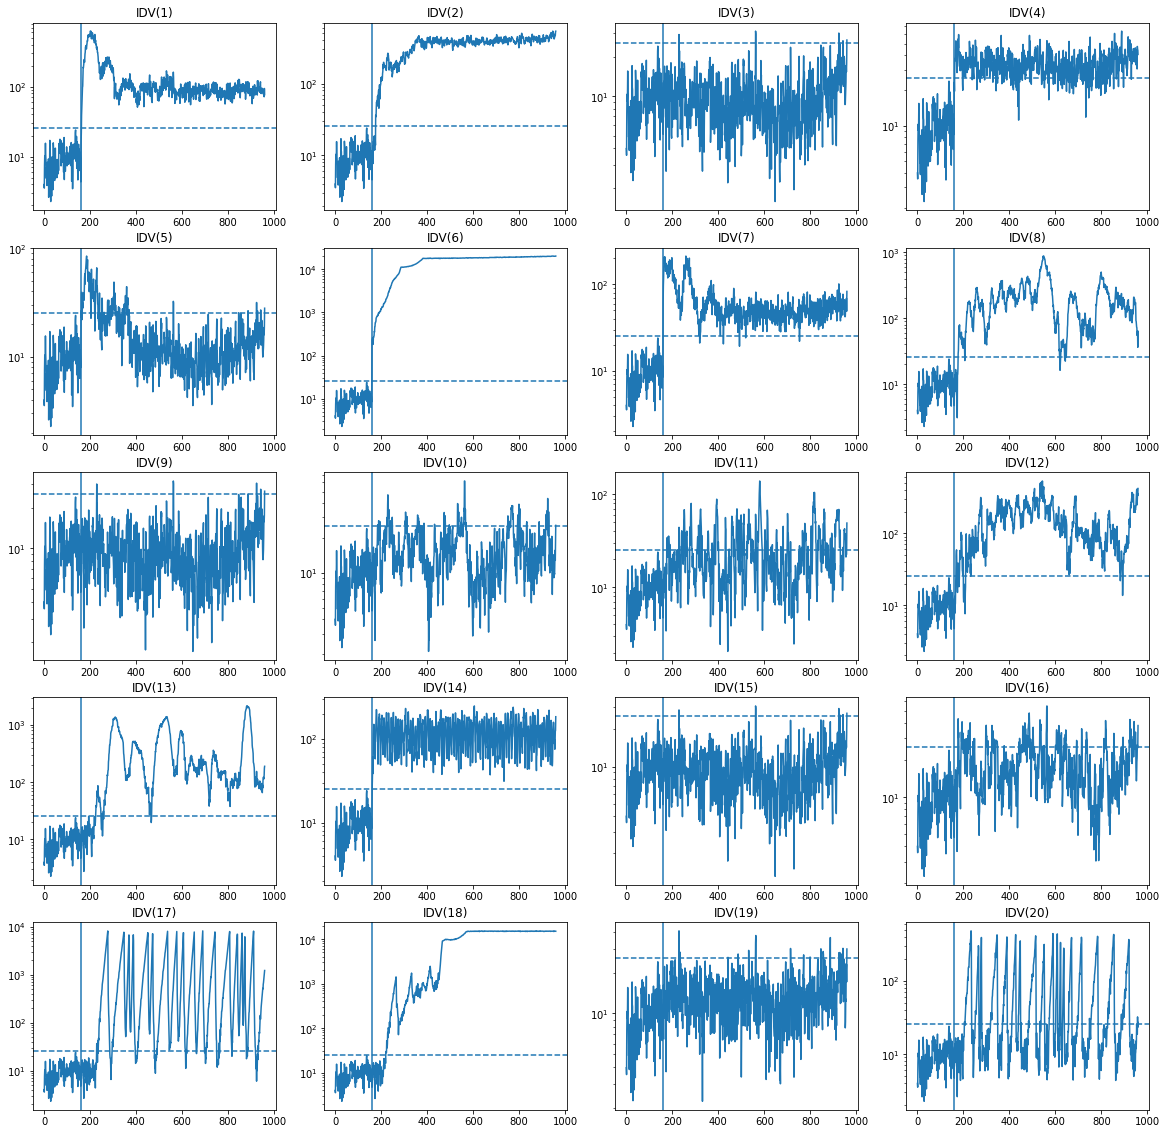

In [16]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

In [17]:
# fdr_df.to_csv('./experimental_result_csv/tsvd30.csv')

## Lag variables

In [18]:
def apply_lag (df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged  

## Noise filtering

In [19]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Adding lag variables

tsvd_lag1    59.656250
tsvd_lag2    61.026283
tsvd_lag3    63.295739
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
tsvd_lag1,99.500000,98.000000,0.25,99.875,12.625000,100.0,100.0,97.750000,0.375000,5.750000,58.875000,97.375000,90.500000,100.0,0.125,11.500000,81.500000,92.250000,2.750000,44.125000
tsvd_lag2,99.749687,98.122653,0.00,100.000,17.396746,100.0,100.0,97.872340,0.000000,8.510638,66.207760,98.122653,91.239049,100.0,0.000,14.142678,82.978723,92.490613,8.010013,45.682103
tsvd_lag3,99.749373,98.621554,0.00,100.000,21.929825,100.0,100.0,97.994987,0.250627,14.285714,73.433584,98.872180,93.233083,100.0,0.000,22.932331,85.087719,92.982456,17.042607,49.498747


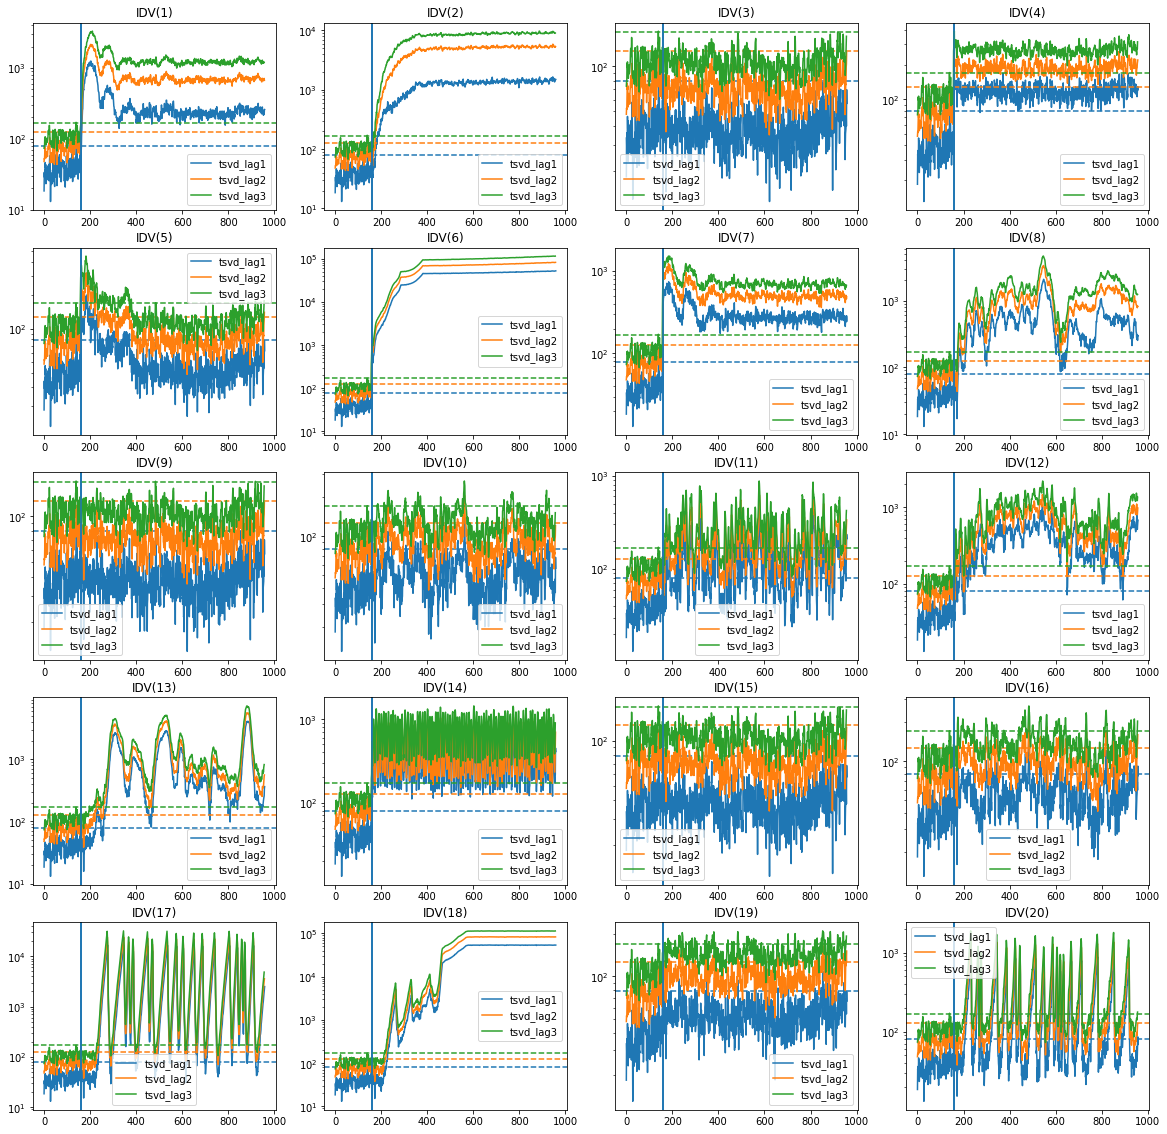

In [20]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'tsvd_lag1': ModelTSVD(30), 'tsvd_lag2': ModelTSVD(30), 'tsvd_lag3': ModelTSVD(30)}
lags = {'tsvd_lag1': 1, 'tsvd_lag2': 2, 'tsvd_lag3': 3}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(apply_lag(df_train,lags[name]))
    spe_validation = model.test(apply_lag(df_validation,lags[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = apply_lag(test_faulty[(test_faulty.faultNumber==i+1) & 
                                        (test_faulty.simulationRun==1)].iloc[:,3:], lags[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [21]:
# fdr_df.to_csv('./experimental_result_csv/tsvdlag.csv')

## Filter noise

WS_10     66.22500
WS_50     61.40000
WS_100    57.79375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,99.250,98.125,0.625,99.625,99.5,99.875,99.875,97.625,1.000,25.625,79.875,98.625,93.625,47.500,0.75,31.250,91.000,93.125,1.125,66.500
WS_50,98.625,97.125,0.125,98.500,99.0,99.500,99.375,96.750,0.250,16.000,55.875,89.375,92.000,1.625,0.00,8.000,90.375,91.875,0.500,93.125
WS_100,98.250,96.250,3.125,95.750,98.5,99.375,98.750,91.125,3.125,6.250,11.500,86.500,89.875,0.500,0.00,1.125,90.000,91.125,2.375,92.375


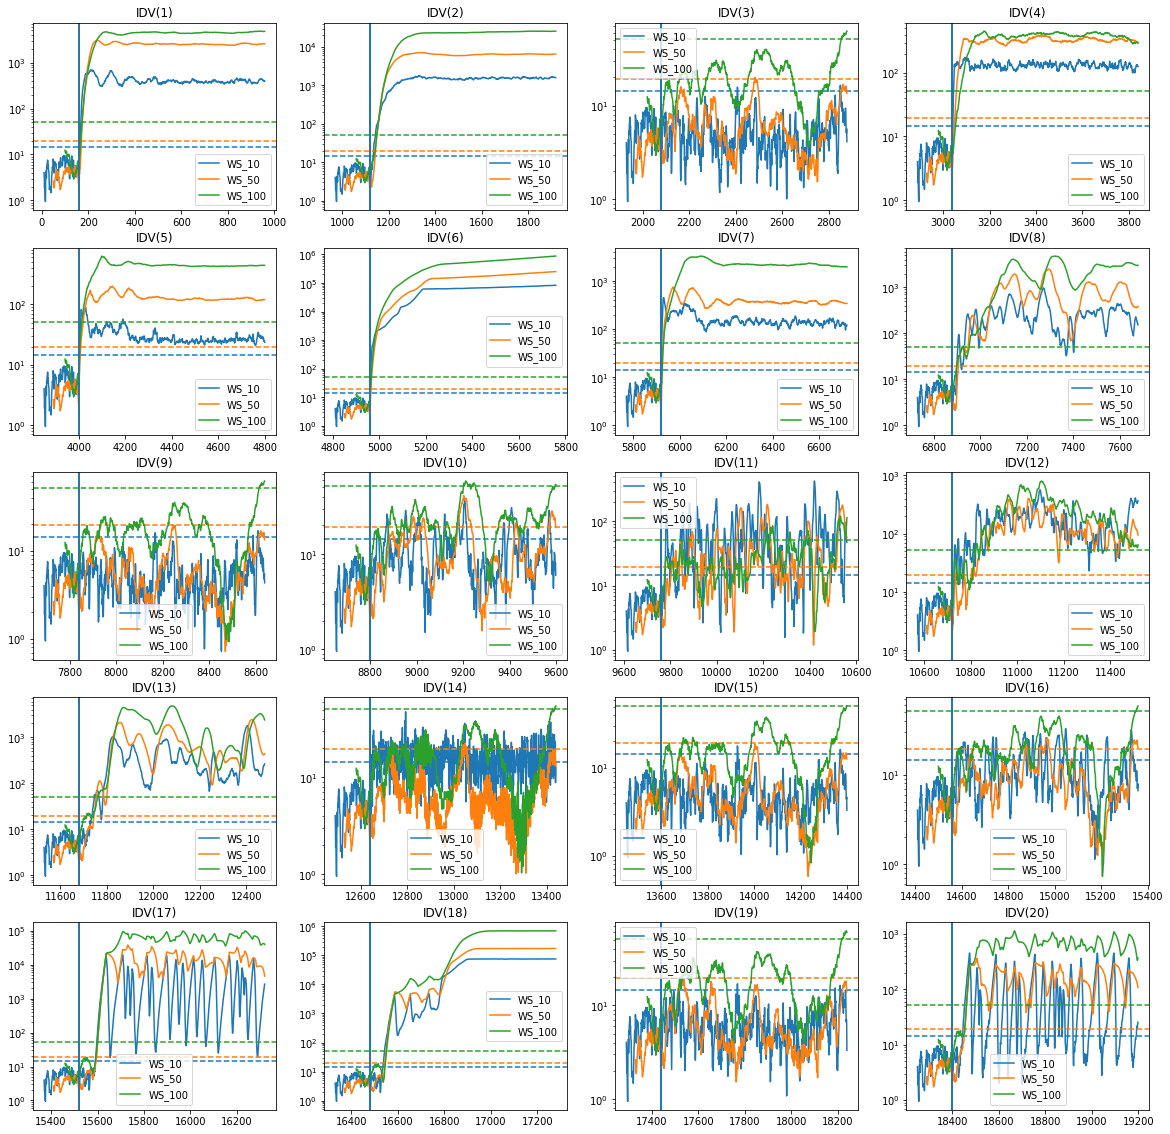

In [22]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelTSVD(30), 'WS_50': ModelTSVD(30), 'WS_100': ModelTSVD(30)}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [23]:
# fdr_df.to_csv('./experimental_result_csv/tsvdnf.csv')